<a href="https://colab.research.google.com/github/blowmeaway1234/Machine-Vision/blob/master/Model_Detection_Basketball_ver1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google Drive Data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Basketball

test.zip  train.zip


In [ ]:
! unzip /content/drive/MyDrive/Basketball/train.zip
! unzip /content/drive/MyDrive/Basketball/test.zip

In [4]:
for i in range(2): # lệnh !ls không hiểu python nên ko dùng '{}'.format i
  !ls test/{i}| wc -l
for i in range(2): # lệnh !ls không hiểu python nên ko dùng '{}'.format i
  !ls train/{i}| wc -l

110
110
180
775


# Build Data Pipe line

In [64]:
# import library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam 

In [65]:
# Part data train
train_root = Path('train/')
filelist_Training = tf.data.Dataset.list_files(str(train_root/'*/*')) 
# Part data test
test_root = Path('test/')
filelist_Testing = tf.data.Dataset.list_files(str(test_root/'*/*')) 


In [66]:
for file in filelist_Training.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8
for file in filelist_Testing.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8

filename: train/1/m (230).jpg
filename: train/0/n (135).jpg
filename: test/1/t (85).jpg
filename: test/1/t (71).jpg


In [67]:
#Preprocessing
def preprocessing(file_path):
  #Readfile
  img1 = tf.io.read_file(file_path)
  img1 = tf.image.decode_jpeg(img1,channels=3) #Read Color image
  img1 = tf.image.rgb_to_grayscale(img1, name=None) # convert to gray scale
  #Transform
  img1 = tf.image.convert_image_dtype(img1,tf.float32) # convert uint8 to float and normalize [0,1]
  #Resize image
  img1 = tf.image.resize(img1,[img_width,img_height])
  #-4. Reshape -> vector hàng
  img1 = tf.reshape(img1,(28,28,1))
  #Get image lable
  label = get_label(file_path) #sự dụng hàm test label vừa tạo
  #Return
  return img1,label

In [68]:
# Make Label
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  if parts[-2] == "0":
    labels=[1,0] 
  else:
    labels=[0,1] 
  return tf.convert_to_tensor(labels)

In [69]:
#Global Value
batch_size= 32                     
img_height = 28
img_width = 28

datatrain_size = 905 #(shuffle size_train) 
datatest_size = 100 #(shuffle test) 

reshapesize= img_height*img_width
print("Value Reshapsize",reshapesize)

Value Reshapsize 784


In [70]:
#build data training
train_dataset = filelist_Training.shuffle(datatrain_size) 
train_dataset = train_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(2) # chia luồn data

In [71]:
#build data testing
test_dataset = filelist_Testing.shuffle(datatest_size) 
test_dataset = test_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(2) # chia luồn data

#Build Model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dropout_2 (Dropout)         (None, 320)              

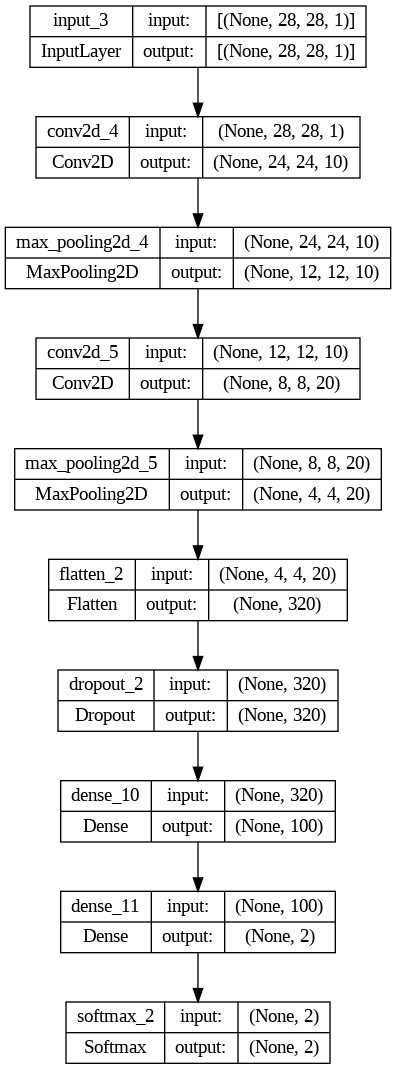

In [72]:
# Build CNN model using function API
# Convolutional Neural Network

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(img_height,img_width,1)))
model.add(layers.Conv2D(10,5, strides=(1,1), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
model.add(layers.Conv2D(20,5,strides=(1,1), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2))
model.add(layers.Softmax())

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy']) # Compile model
model.summary()

# Draw Graph
tf.keras.utils.plot_model(model,'model.png',show_shapes=True)


#Train Model

In [73]:
# Train model
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show()

model.save('CNN_Bask_Rec.h5')

Epoch 1/20
30/30 [==============================] - 107s 3s/step - loss: 0.5503 - accuracy: 0.8042 - val_loss: 0.9626 - val_accuracy: 0.5000
Epoch 2/20
30/30 [==============================] - 101s 3s/step - loss: 0.5126 - accuracy: 0.8157 - val_loss: 1.0649 - val_accuracy: 0.5000


KeyboardInterrupt: ignored

# Evaluate

In [ ]:
# Evaluate model on test dataset
evaluation = model.evaluate(test_dataset)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Predict the label of the test data file
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to label indices

# Convert actual labels from one-hot encoding to integer format
y_true = []
for _, label in test_dataset:
    y_true.extend(np.argmax(label, axis=1))

# Calculate evaluation metrics
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

#Draw ConFusion MaTrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()